In [ ]:
pip install fenics

In [ ]:
!apt-get install --no-install-recommends fenics

In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:46
🔁 Restarting kernel...


Тут ядро дохнет, так надо

In [2]:
!conda config --add channels conda-forge

In [ ]:
!conda install fenics

In [4]:
from fenics import *
from dolfin import *

In [5]:
!pip install git+https://github.com/dolfin-adjoint/pyadjoint.git@2019.1.0


  Cloning https://github.com/dolfin-adjoint/pyadjoint.git (to revision 2019.1.0) to /tmp/pip-req-build-kwh742_d
  Running command git clone -q https://github.com/dolfin-adjoint/pyadjoint.git /tmp/pip-req-build-kwh742_d
  Running command git checkout -q 6c2363bc23f0260a7a1988852c358105f31d38c7
     |████████████████████████████████| 27.4 MB 49 kB/s 
  Created wheel for dolfin-adjoint: filename=dolfin_adjoint-2019.1.0-py3-none-any.whl size=85020 sha256=7dec90b5e59179df34fcfacbe66505e1d4286bdfb32652a242dfbe333c5f8288
  Stored in directory: /tmp/pip-ephem-wheel-cache-5sz85om1/wheels/65/8f/a5/b5a2dc1cac4916ff17cb60a748b5473c2e37be39cd415baadb
Successfully built dolfin-adjoint


In [6]:
import fenics_adjoint

Тест

In [7]:
from dolfin import *

from dolfin_adjoint import *

In [8]:
!pip install moola

     |████████████████████████████████| 52 kB 421 kB/s 


In [9]:
import moola

In [10]:
n = 64
mesh = UnitSquareMesh(n, n)

cf = MeshFunction("bool", mesh, mesh.geometric_dimension())
subdomain = CompiledSubDomain('std::abs(x[0]-0.5) < 0.25 && std::abs(x[1]-0.5) < 0.25')
subdomain.mark(cf, True)
mesh = refine(mesh, cf)

In [11]:
V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)

f = interpolate(Expression("x[0]+x[1]", name='Control', degree=1), W)
u = Function(V, name='State')
v = TestFunction(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [12]:
F = (inner(grad(u), grad(v)) - f * v) * dx
bc = DirichletBC(V, 0.0, "on_boundary")
solve(F == 0, u, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [13]:
x = SpatialCoordinate(mesh)
w = Expression("sin(pi*x[0])*sin(pi*x[1])", degree=3)
d = 1 / (2 * pi ** 2)
d = Expression("d*w", d=d, w=w, degree=3)


In [14]:
alpha = Constant(1e-6)
J = assemble((0.5 * inner(u - d, u - d)) * dx + alpha / 2 * f ** 2 * dx)
control = Control(f)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [15]:
rf = ReducedFunctional(J, control)

In [16]:
problem = MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-9,
                                                   'maxiter': 20,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [17]:
solver = moola.BFGS(problem, f_moola, options={'jtol': 0,
                                               'gtol': 1e-9,
                                               'Hinit': "default",
                                               'maxiter': 100,
                                               'mem_lim': 10})

L-BFGS method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 100

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
iteration = 0:	objective = 0.00014965968652145485:	grad_norm = 0.000805979390707312:
-g 0.000805979390707312
iteration = 1:	objective = 2.0374011482619616e-05:	grad_norm = 0.00010712769056805015:	delta_J = 0.00012928567503883525:
-g 4.488801984484816e-06
iteration = 2:	objective = 1.6215590303848852e-05:	grad_norm = 9.146895746674933e-05:	delta_J = 4.158421178770764e-06:
-g 2.447233343506009e-05
iteration = 3:	objective = 3.1400127737429937e-06:	grad_norm = 2.2402342128988104e-05:	delta_J = 1.307557

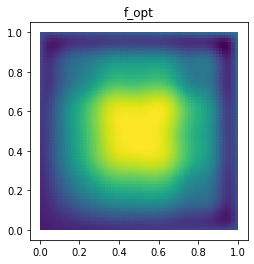

In [18]:
sol = solver.solve()
f_opt = sol['control'].data

plot(f_opt, title="f_opt")

# Define the expressions of the analytical solution
f_analytic = Expression("1/(1+alpha*4*pow(pi, 4))*w", w=w, alpha=alpha, degree=3)
u_analytic = Expression("1/(2*pow(pi, 2))*f", f=f_analytic, degree=3)

In [19]:
f.assign(f_opt)
solve(F == 0, u, bc)
control_error = errornorm(f_analytic, f_opt)
state_error = errornorm(u_analytic, u)
print("h(min):           %e." % mesh.hmin())
print("Error in state:   %e." % state_error)
print("Error in control: %e." % control_error)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
h(min):           1.104854e-02.
Error in state:   3.970729e-05.
Error in control: 4.677820e-02.
